# Gas consumption data

We first import the right modules

In [2]:
# For arrays and other numerical operations (any function from this module can be used by typing np.FunctionName)
import numpy as np
# Import specifically the inverse function and the block diagonal function which can be used without prefix
from numpy.linalg import inv
from scipy.linalg import block_diag

# For plotting
import matplotlib.pyplot as plt

Then we define the general Kalman filter

In [4]:
def Kalman_filter(y, m0, P0, F, H, U, V, n, xdim, delta):
    # y       data array (dim d' x N with N the total number of data points)
    # m0      prior mean (dim d)
    # P0      prior variance (dim d x d)
    # F       transition matrix (dim d x d)
    # H       observation matrix (dim d' x d)
    # U       transition noise covariance (dim d x d)
    # V       observatiion noise variance (dim d' x d')
    # n       number of time steps to be processed
    # xdim    dimension of the state (same as d)
    # delta   number of predictive time steps (last observation used n - delta - 1)
    
    mu = np.zeros((xdim, n))
    Pu = np.zeros((xdim, xdim, n))
    mp = np.zeros((xdim, n))
    Pp = np.zeros((xdim, xdim, n))
    mp[:, 0] = m0
    Pp[:, :, 0] = P0
    for k in range(n):
        if k < n - delta:
            # Update
            z = y[:, k] - np.matmul(H, mp[:, k])
            S = np.matmul(np.matmul(H, Pp[:, :, k]), H.transpose()) + V
            K = np.matmul(np.matmul(Pp[:, :, k], H.transpose()), inv(S))
            mu[:, k] = mp[:, k] + np.matmul(K, z)
            Pu[:, :, k] = np.matmul(np.eye(xdim) - np.matmul(K, H), Pp[:, :, k])
        else:
            mu[:, k] = mp[:, k]
            Pu[:, :, k] = Pp[:, :, k]
        
        if k < n-1:
            # Prediction
            mp[:, k+1] = np.matmul(F, mu[:, k])
            Pp[:, :, k+1] = np.matmul(np.matmul(F, Pu[:, :, k]), F.transpose()) + U
    return mp, Pp, mu, Pu

And a function returning the rotation matrix $R(\omega)$

In [5]:
def rotation_mat(omega):
    cw = np.cos(omega)
    sw = np.sin(omega)
    return np.array([[cw, sw],[-sw, cw]])

## The data

In [6]:
# Array of data (rows are months (January to December) and columns are years)
data = np.array([[0, 8.3, 7.7, 8.5, 7.7, 8.8],
                 [0, 7.2, 7.7, 7.9, 9.0, 8.7],
                 [0, 9.2, 8.9, 8.9, 9.0, 10.1],
                 [0, 5.5, 5.7, 5.4, 6.5, 6.1],
                 [4.9, 4.7, 5.0, 4.4, 5.1, 5.0],
                 [4.5, 4.4, 4.5, 4.0, 4.3, 4.5],
                 [3.1, 3.4, 3.3, 3.0, 2.7, 3.1],
                 [3.1, 2.8, 2.8, 3.1, 2.8, 2.9],
                 [4.6, 4.0, 4.0, 4.4, 4.6, 4.8],
                 [4.8, 5.1, 5.6, 5.5, 5.5, 0],
                 [6.7, 6.5, 6.6, 6.5, 6.9, 0],
                [8.6, 9.2, 10.3, 10.1, 9.5, 0]])

In [7]:
# Reshape the data into one row vector and remove zeros at the start and end
y = (data.T).reshape(1,72)[:, 4:-3]

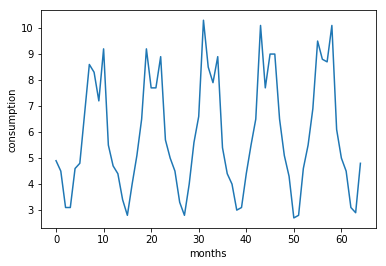

In [8]:
# Plot the data
plt.plot(y[0, :])
plt.xlabel('months')
plt.ylabel('consumption');

In [9]:
# All data points are considered for filtering
n = len(y[0, :])

# The period is 12 months
p = 12
omega = 2*np.pi / p

# Observation noise (we assume the observations are rather accurate)
V = 0.1 * np.eye(1)

## A simple model

In [13]:
# Superposition of a first-order model and a simple Fourier-form seasonal model
F = block_diag(1, rotation_mat(omega))
H = np.array([[1, 1, 0]])

# Uninformative prior (large covariance)
m0 = np.array([0, 0, 0])
P0 = 100*np.eye(3) # np.eye(d) is the identity matrix of dimension d

# The first-order model does not evolve much but the are changes in the cycles
U = np.array([[0.01, 0 , 0], [0, 1, 0],[0, 0, 1]])

### Filtering

In [14]:
# We try to predict the last 24 time steps (2 years)
delta = 24
(mp, Pp, mu, Pu) = Kalman_filter(y, m0, P0, F, H, U, V, n, 3, delta)

### Plot of the results

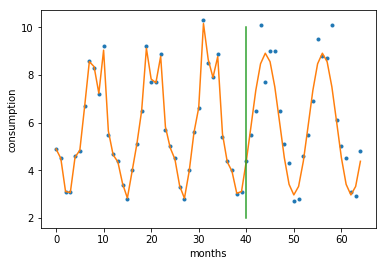

In [15]:
# The data 
plt.plot(y[0, :], '.')

# The posterior/predictive mean
plt.plot(np.matmul(H, mu)[0, :], '-')

# Vertical line showing where forecasting starts
plt.plot([n-delta-1, n-delta-1], [2, 10])
plt.xlabel('months')
plt.ylabel('consumption');

## A more complex model

In [18]:
# Superposition of a first-order model and a more complex Fourier-form seasonal model
F = block_diag(1, rotation_mat(omega), rotation_mat(2*omega), rotation_mat(3*omega), rotation_mat(4*omega))
H = np.array([[1, 1, 0, 1, 0, 1, 0, 1, 0]])

# Uninformative prior (large covariance)
m0 = np.zeros(9)
P0 = 25 * np.eye(9) # np.eye(d) is the identity matrix of dimension d

# Less noise is required as the model is more accurate
U = 0.01 * np.eye(9)
U[0, 0] = 0.01

### Filtering

In [19]:
# We try to predict the last 24 time steps (2 years)
delta = 24
(mp, Pp, mu, Pu) = Kalman_filter(y, m0, P0, F, H, U, V, n, 9, delta)

### Plot of the results

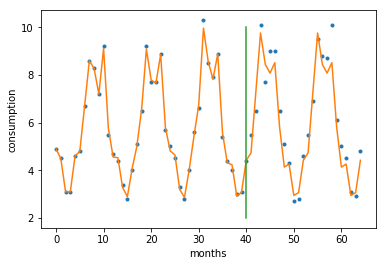

In [20]:
# The data 
plt.plot(y[0, :], '.')
# The posterior/predictive mean
pred_mean = np.matmul(H, mu)[0, :]
plt.plot(pred_mean, '-');
# Vertical line showing where forecasting starts
plt.plot([n-delta-1, n-delta-1], [2, 10])
plt.xlabel('months')
plt.ylabel('consumption');

We would like to check how certain we are of our forcast

In [21]:
# Compute the posterior/predicted standard deviation 
pred_std_dev = np.zeros(n)
for k in range(n):
    pred_std_dev[k] = np.sqrt(np.matmul(np.matmul(H, Pu[:, :, k]), H.T) + V)

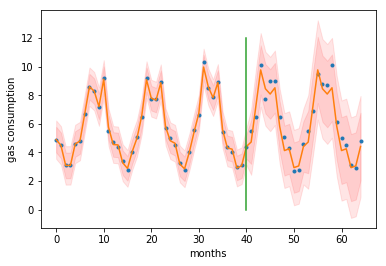

In [22]:
# The data 
plt.plot(y[0, :], '.')

# The posterior/predictive mean
plt.plot(pred_mean, '-');

# The uncertainty
for i in range(2,4):
    plt.fill_between(np.linspace(0,n-1,n),
                 y1=pred_mean-i*pred_std_dev,
                 y2=pred_mean+i*pred_std_dev, color='r', alpha=.1)
# Vertical line showing where forecasting starts
plt.plot([n-delta-1, n-delta-1], [0, 12])
plt.xlabel('months')
plt.ylabel('gas consumption');

Let's look at the individual components

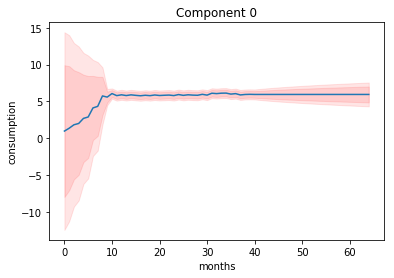

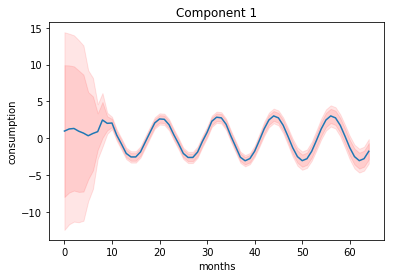

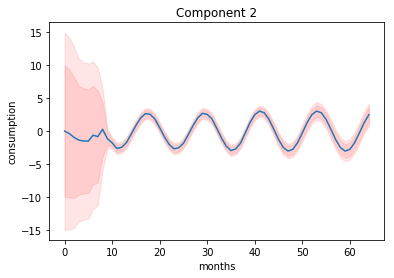

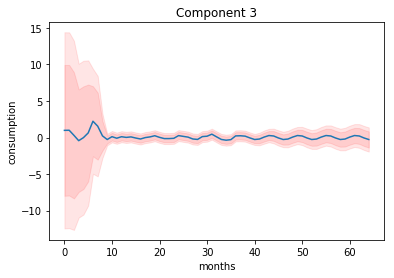

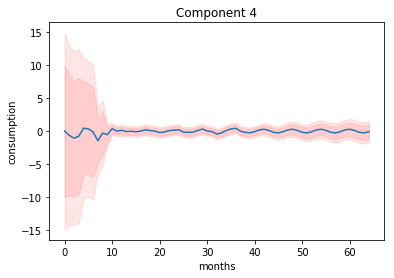

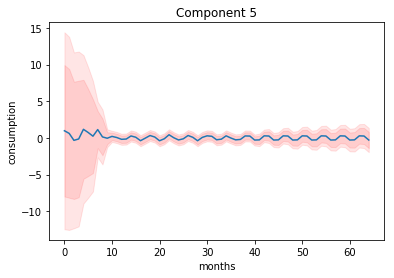

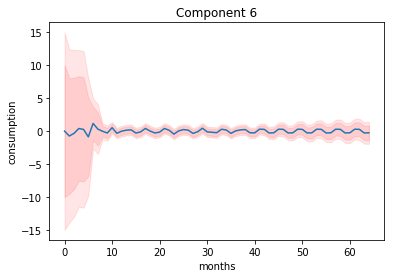

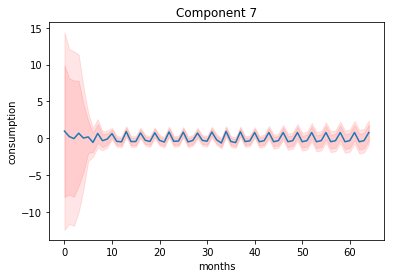

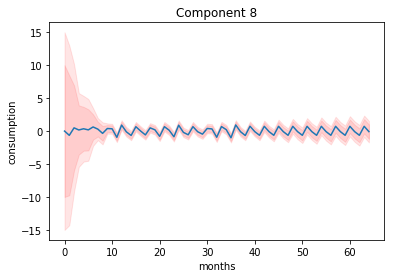

In [23]:
# Loop on the different components of the state
for comp in range(9):
    plt.figure()
    pred_mean = mu[comp, :]
    pred_std_dev = np.zeros(n)
    for k in range(n):
        pred_std_dev[k] = np.sqrt(Pu[comp, comp, k])

    # The posterior/predictive mean
    plt.plot(pred_mean, '-');

    # The uncertainty
    for i in range(2,4):
        plt.fill_between(np.linspace(0,n-1,n),
                     y1=pred_mean-i*pred_std_dev,
                     y2=pred_mean+i*pred_std_dev, color='r', alpha=.1)
        plt.xlabel('months')
        plt.ylabel('consumption')
        plt.title('Component '+str(comp))


It appears in figures above that the components 3 to 6 (corresponding to $2\omega$ and $3\omega$) do not contribute much to the estimate, so we can try to remove them

## A simpler (but not too simple) model

In [24]:
# Superposition of a first-order model and a simpler Fourier-form seasonal model
F = block_diag(1, rotation_mat(omega), rotation_mat(4*omega))
H = np.array([[1, 1, 0, 1, 0]])

# Uninformative prior (large covariance)
m0 = np.zeros(5)
P0 = 25 * np.eye(5) # np.eye(d) is the identity matrix of dimension d

# Less noise is required as the model is more accurate
U = 0.01 * np.eye(5)
U[0, 0] = 0.01

### Filtering

In [25]:
# We try to predict the last 24 time steps (2 years)
delta = 24
(mp, Pp, mu, Pu) = Kalman_filter(y, m0, P0, F, H, U, V, n, 5, delta)

### Plot of the results

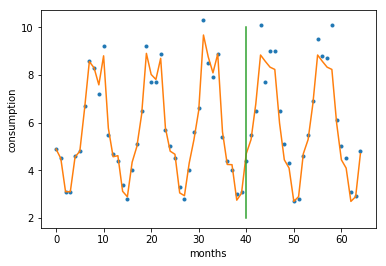

In [26]:
# The data 
plt.plot(y[0, :], '.')
# The posterior/predictive mean
pred_mean = np.matmul(H, mu)[0, :]
plt.plot(pred_mean, '-');
# Vertical line showing where forecasting starts
plt.plot([n-delta-1, n-delta-1], [2, 10])
plt.xlabel('months')
plt.ylabel('consumption');

In [27]:
# Compute the posterior/predicted standard deviation 
pred_std_dev = np.zeros(n)
for k in range(n):
    pred_std_dev[k] = np.sqrt(np.matmul(np.matmul(H, Pu[:, :, k]), H.T) + V)

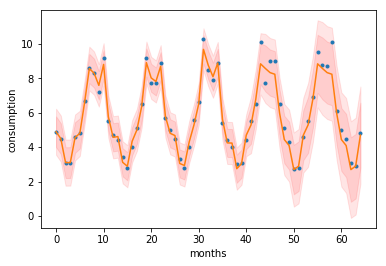

In [28]:
# The data 
plt.plot(y[0, :], '.')

# The posterior/predictive mean
plt.plot(pred_mean, '-');

# The uncertainty
for i in range(2,4):
    plt.fill_between(np.linspace(0,n-1,n),
                 y1=pred_mean-i*pred_std_dev,
                 y2=pred_mean+i*pred_std_dev, color='r', alpha=.1)
plt.xlabel('months')
plt.ylabel('consumption');